# Motor de Recomendación - Banco de Recursos de SIFODS
-El centro de recursos de la plataforma educativa virtual del Sistema Integrado de Formación Docente en Servicio (SIFODS) tiene como finalidad de ofrecer a todos los docentes la oportunidad de acceder a una formación docente en servicio, pertinente y de calidad, de manera versátil, flexible y promoviendo la autoformación. 

-El objetivo del proyecto es desarrollar un modelo analítico de recomendación que pueda ayudar a los usuarios del Centro de recursos a encontrar los recursos más relevantes y útiles para sus necesidades individuales.

-El proyecto se basa en técnicas de ciencia de datos y aprendizaje automático para analizar los datos disponibles del Centro de Recursos y generar recomendaciones personalizadas para los usuarios. Estos datos incluyen información sobre los usuarios, como su historial de descargas , calificaciones. Adicional se incluyen datos sobre las características del propio recurso , como las categorías , resumen, título.

## 1. Recopilación de Datos

In [91]:
#Librerias
import pandas as pd 
import numpy as np
import pyodbc
import re 
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity


import warnings
warnings.filterwarnings('ignore')

In [92]:
# Credenciales 
conn = pyodbc.connect(DRIVER = '{ODBC Driver 17 for SQL Server}',
                      SERVER = 'med000008646',
                      DATABASE = 'BD_STAGE',
                      UID = 'usconsulta',
                      PWD = 'consulta')

In [93]:
#Extraccion del dataset inical 
## maestro de cursos de la oferta formativa 
query1 = """SELECT  A.ID,
		A.TITULO, 
		A.RESUMEN,
		B.DESCRIPCION AS CATEGORIA , 
		C.DESCRIPCION AS TIPO_RECURSO,
		D.DESCRIPCION AS SUB_CATEGORIA, 
		E.DESCRIPCION AS SEGUNDA,
		F.DESCRIPCION AS TERCERA,
		G.DESCRIPCION AS CUARTA,
		A.DESCARGAS,
		A.VISTAS
	FROM [st].[SI_acfm.transaccional.accion_formativa_banco_recurso] A
	LEFT JOIN [st].[SI_dbo.maestro.parametros] B on A.CATEGORIA_ID = B.ID
	LEFT JOIN [st].[SI_dbo.maestro.parametros] C on A.TIPORECURSO = C.ID
	LEFT JOIN [st].[SI_dbo.maestro.parametros] D on A.SUB_CATEGORIA_ID = D.ID
	LEFT JOIN [st].[SI_dbo.maestro.parametros] E on A.SEGUNDA_SUBCATEGORIA_ID=E.ID
	LEFT JOIN [st].[SI_dbo.maestro.parametros] F on A.TERCERA_SUBCATEGORIA_ID=F.ID
	LEFT JOIN [st].[SI_dbo.maestro.parametros] G on A.CUARTA_SUBCATEGORIA_ID=G.ID
	WHERE A.ESTADO=1"""
    
banco_recursos_df = pd.read_sql_query(query1,conn)


## interacciones del usuario con sifods
query2 = """SELECT ID,
                    DNI,
                    ACCIONFORMATIVABANCORECURSOID,
                    PREFERENCIA,
                    VISTA,
                    DESCARGA,
                    CALIFICACION
            FROM [st].[SI_acfm.transaccional.banco_recurso_like]
            WHERE ESTADO=1"""
acciones_df = pd.read_sql_query(query2,conn)


#Cerrar la conexion
conn.close()

**DataFrame Extraidos**

In [94]:
banco_recursos_df.head(3)

,ID,TITULO,RESUMEN,CATEGORIA,TIPO_RECURSO,SUB_CATEGORIA,SEGUNDA,TERCERA,CUARTA,DESCARGAS,VISTAS
0,770,Comunicación 1: Cuaderno de trabajo,Presenta actividades que permiten el desarroll...,Material Educativo,Cuaderno de trabajo,None,None,None,None,2,9
1,1423,Augdaiyaku 1 - Tajimat pujut augdaiyaku - Leng...,Portafolio de evidencias para estudiantes del ...,Material Educativo,Cuaderno de trabajo,None,None,None,None,0,0
2,1425,Augdaiyaku 2 - Tajimat pujut augdaiyaku - Leng...,Portafolio de evidencias para estudiantes del ...,Material Educativo,Cuaderno de trabajo,None,None,None,None,0,0


In [95]:
acciones_df.head(3)

,ID,DNI,ACCIONFORMATIVABANCORECURSOID,PREFERENCIA,VISTA,DESCARGA,CALIFICACION
0,1,26718640,2513,False,1,0,0
1,2,31036655,2293,False,1,0,0
2,3,71481859,1216,False,1,0,0


## 2. Selección, limpieza y transformación

**Banco de recursos** 

In [96]:
def reemplazar_special_carac(text):
    #Remover caracteres especiales de la columna
    pattern = r'[^a-zA-Z\sñÑáéíóúÁÉÍÓÚ]'
    return re.sub(pattern,'', text)

In [97]:
banco_recursos_df['TITULO'] = banco_recursos_df['TITULO'].apply(reemplazar_special_carac)
banco_recursos_df['RESUMEN'] = banco_recursos_df['RESUMEN'].apply(reemplazar_special_carac)

In [98]:
banco_recursos_df.TITULO.head(3)

0                    Comunicación  Cuaderno de trabajo
1    Augdaiyaku   Tajimat pujut augdaiyaku  Lengua ...
2    Augdaiyaku   Tajimat pujut augdaiyaku  Lengua ...
Name: TITULO, dtype: object

In [99]:
banco_recursos_df.RESUMEN.head(3)

0    Presenta actividades que permiten el desarroll...
1    Portafolio de evidencias para estudiantes del ...
2    Portafolio de evidencias para estudiantes del ...
Name: RESUMEN, dtype: object

**Acciones Banco de Recursos**

In [100]:
#Quitar los registros que no estan en la lista de banco de recursos con interacciones
acciones_df_validos = acciones_df[acciones_df['ACCIONFORMATIVABANCORECURSOID'].isin(banco_recursos_df['ID'])]

In [101]:
acciones_df_validos =acciones_df_validos[acciones_df_validos['DESCARGA']>0]

In [102]:
usuarios_con_interacciones = acciones_df_validos.groupby('DNI')['ACCIONFORMATIVABANCORECURSOID'].size()
usuarios_con_interacciones
print("# usuarios : %d" %len(usuarios_con_interacciones))
usuarios_seleccionados = usuarios_con_interacciones[usuarios_con_interacciones > 1].reset_index()[['DNI']]
print("# usuarios seleccionados %d"  %len(usuarios_seleccionados))

# usuarios : 413
# usuarios seleccionados 236


In [103]:
print("# de interaciones total : %d" %len(acciones_df_validos))

acciones_df_validos_2 = acciones_df_validos.merge(usuarios_seleccionados, how="right", left_on="DNI",right_on="DNI")

print("# de interacciones seleccionadas : %d" %len(acciones_df_validos_2))


# de interaciones total : 3592
# de interacciones seleccionadas : 3415


## Análisis Descriptivo Estadistico

In [104]:
print("# de recursos registrados : %d" %len(banco_recursos_df))

# de recursos registrados : 3029


CATEGORIA
Herramientas de apoyo docente       679
Material Educativo                 1800
Recursos de Acciones Formativas     550
dtype: int64


<Axes: title={'center': 'CATEGORIA BANCO DE RECURSOS'}, ylabel='CATEGORIA'>

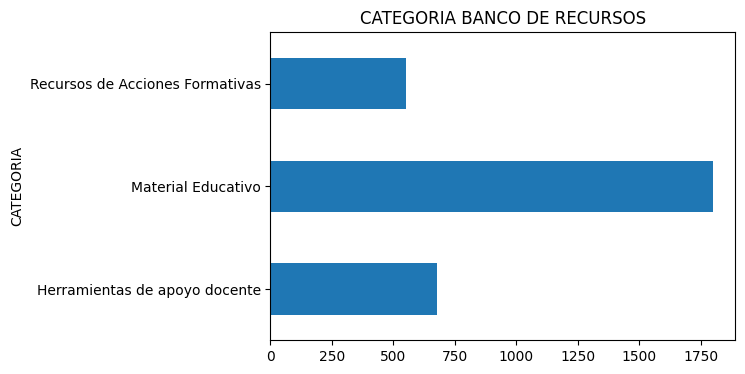

In [105]:
g_categoria = banco_recursos_df.groupby('CATEGORIA').size()
print(g_categoria)
g_categoria.plot(kind='barh',title='CATEGORIA BANCO DE RECURSOS',figsize=(6,4))

TIPO_RECURSO
Infografía                3
Modelado                  5
Lámina                    9
Audio                    11
Manual                   16
Orientaciones            31
Prueba                   33
Registro                 33
Cartilla                 39
Texto escolar            49
Sílabo                   89
Caja de herramientas    169
Guía                    186
Ficha                   249
Video                   262
Libro                   279
Texto                   285
Fascículo               332
Cuaderno de trabajo     949
dtype: int64


<Axes: title={'center': 'Tipos de Recursos'}, ylabel='TIPO_RECURSO'>

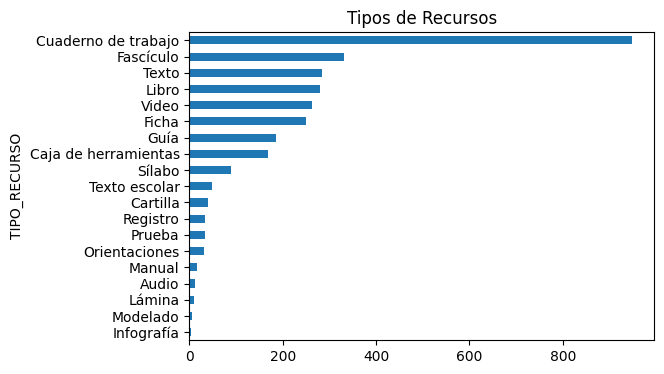

In [106]:
g_tiporecurso = banco_recursos_df.groupby('TIPO_RECURSO').size().sort_values()
print(g_tiporecurso)
g_tiporecurso.plot(kind='barh',title='Tipos de Recursos',figsize=(6,4))

<Axes: title={'center': 'Frecuencia de Descargas del Banco de Recursos - SIFODS'}, ylabel='Frequency'>

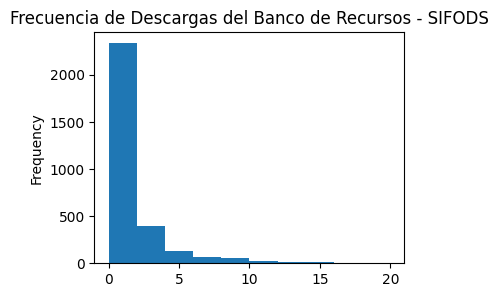

In [107]:
v1 = banco_recursos_df['DESCARGAS']
v1.plot.hist(title ='Frecuencia de Descargas del Banco de Recursos - SIFODS',figsize=(4,3),range=(0,20))

<Axes: title={'center': 'Frecuencia de VISTAS del Banco de Recursos - SIFODS'}, ylabel='Frequency'>

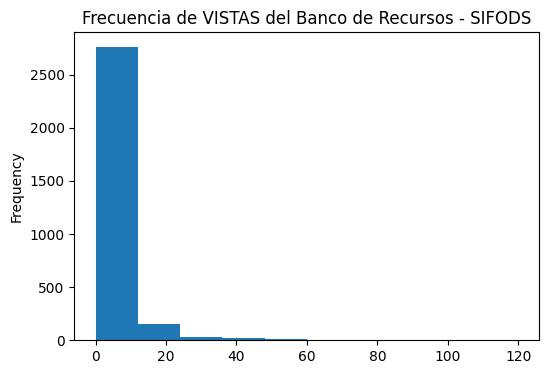

In [108]:
v2 = banco_recursos_df['VISTAS']
v2.plot.hist(title ='Frecuencia de VISTAS del Banco de Recursos - SIFODS',figsize=(6,4),range=(0,120))

<Axes: xlabel='DESCARGA', ylabel='VISTA'>

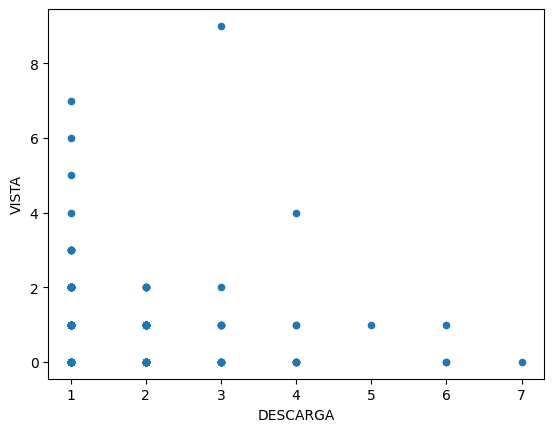

In [109]:
acciones_df_validos_2.plot(kind="scatter",x='DESCARGA',y='VISTA')

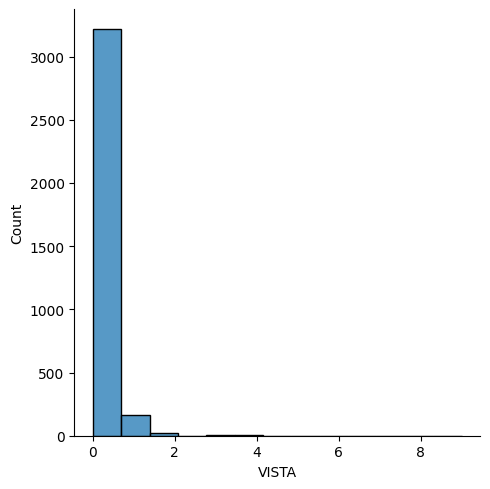

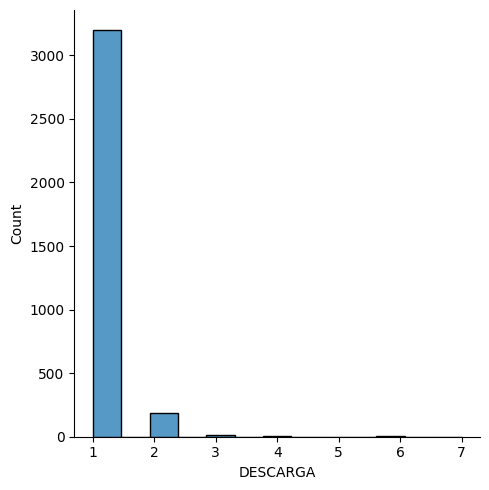

In [112]:
sns.displot(acciones_df_validos_2, x='VISTA')
sns.displot(acciones_df_validos_2, x='DESCARGA')


In [113]:
acciones_df_validos_2[acciones_df_validos_2['VISTA']==0]

,ID,DNI,ACCIONFORMATIVABANCORECURSOID,PREFERENCIA,VISTA,DESCARGA,CALIFICACION
0,24933,00067813,1983,False,0,1,0
1,24934,00067813,1842,False,0,1,0
2,29841,00093691,2291,False,0,1,0
3,29842,00093691,2268,False,0,1,0
4,27726,00103604,2272,False,0,1,0
...,...,...,...,...,...,...,...
3410,813,80390655,1347,False,0,1,0
3411,815,80390655,1346,False,0,1,0
3412,816,80390655,1345,False,0,1,0
3413,817,80390655,1344,False,0,1,0


In [114]:
# Numero de docentes unicos 
num_docentes=acciones_df_validos_2['DNI'].unique()
print("# de docentes con acciones en el banco de recursos : "  + str(len(num_docentes)))

# de docentes con acciones en el banco de recursos : 236


In [115]:
num_recursos = acciones_df_validos_2['ACCIONFORMATIVABANCORECURSOID'].unique()
print("# de recursos descargados : " + str(len(num_recursos)))

# de recursos descargados : 1183


In [116]:
#Numero de registros total para el modelo
num_registros_total = len(acciones_df_validos_2)
print("# registros para el modelo : " + str(num_registros_total))

# registros para el modelo : 3415


**Selección de Variables**

- Para el analisis se realiza el procentaje de datos en la variable de acciones como son: VISTA , DESCARGA y CALIFICACIÓN
donde se presentan escases de datos

In [117]:
porcentaje_vista_validos = round((len(acciones_df_validos[acciones_df_validos["VISTA"] >= 1])/ len(acciones_df_validos)*100),1)
porcentaje_descarga_validos = round((len(acciones_df_validos[acciones_df_validos["DESCARGA"] >= 1])/ len(acciones_df_validos)*100),1)
porcentaje_calificacion_validos = round((len(acciones_df_validos[acciones_df_validos["CALIFICACION"] >= 1])/ len(acciones_df_validos)*100),1)


print("Porcentaje de datos en la variable VISTA: " + str(porcentaje_vista_validos) + "%")
print("Porcentaje de datos en la variable DESCARGA: " + str(porcentaje_descarga_validos) + "%")
print("Porcentaje de datos en la variable CALIFICACIÓN: " + str(porcentaje_calificacion_validos) + "%")

Porcentaje de datos en la variable VISTA: 7.0%
Porcentaje de datos en la variable DESCARGA: 100.0%
Porcentaje de datos en la variable CALIFICACIÓN: 0.3%


- Recursos mas descargados y visualizados para sugerir a usuarios nuevos los cuales no tengas interacciones con los recursos

In [118]:
# Recurso mas descargado
recurso_popular_df =acciones_df_validos.groupby('ACCIONFORMATIVABANCORECURSOID')['DESCARGA'].sum().to_frame('SUMD').reset_index()
recurso_popular_df = recurso_popular_df.merge(banco_recursos_df,how='inner',left_on='ACCIONFORMATIVABANCORECURSOID',right_on='ID').sort_values(by='DESCARGAS',ascending=False)
recurso_popular_df[['ID','TITULO','SUMD']].head(5)

,ID,TITULO,SUMD
859,2516,Comunicación VI ciclo Recurso bibliográfico A...,47
677,2330,Guía para la investigación y citado de fuentes...,43
666,2318,Fichas de actividades de la competencia Indaga...,29
949,2787,Fascículo U Curso Ciudadanía digital,26
857,2514,Comunicación VI ciclo Recurso bibliográfico C...,21


In [119]:
acciones_full_df = acciones_df_validos_2[['ID','DNI','ACCIONFORMATIVABANCORECURSOID','DESCARGA']]
interactions_indexed_df = acciones_full_df.set_index("DNI")

## 3.Mineria de Datos - Algoritmo basado en Contenido

<p>
TF-IDF divide el número de veces que una palabra ocurre en un documento en función de la proporción de todos los documentos en la que aparecere una palabra.
</p>

In [120]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords #librerias para los stopwords
import scipy
import sklearn

In [121]:
#ingnorar las palabras sin semantica del español
stopwords_list = stopwords.words('spanish')

stopwords_list.extend(['yine'])

item_ids = banco_recursos_df['ID'].tolist()
tfidf_matrix = TfidfVectorizer().fit_transform(banco_recursos_df['TITULO'] +" " +banco_recursos_df['RESUMEN'])


<p>Para transformar nuestros datos, importamos TfidfVectorizer () de sklearn. Lo instanciamos a una variable; tfdfvec en este caso. De forma predeterminada, el vectorizador genera una función para cada palabra en cada documento, que son muchas funciones. Podemos especificar restricciones en las características que se generan. Primero, establecemos el argumento min_df en 5. Esto limita nuestras funciones a solo aquellas que han ocurrido en al menos dos documentos. Útil ya que los términos que aparecen una vez no son valiosos para encontrar similitudes. También deberiamos eliminar las palabras que son demasiado comunes usando max_df  . Al establecer en 0.7 , se excluiran las palabras que aparezcan en más del 70% de las descripciones con un maximo numero de vectores de 500 compuesto por los principales inigramas y bigramas encontrados.   </p>

In [299]:
tfidfvec = TfidfVectorizer(analyzer='word',min_df=5,ngram_range=(1,2), max_df=0.7,stop_words=stopwords_list,max_features=500)
vectorized_data = tfidfvec.fit_transform(banco_recursos_df['TITULO']+" "+banco_recursos_df['RESUMEN'])
print(tfidfvec.get_feature_names_out())

['actividad' 'actividades' 'actividades apoyan' 'actividades calendario'
 'actividades desarrollan' 'actividades evaluación'
 'actividades evidencian' 'actividades socioproductivas'
 'actividades surgen' 'acuerdo' 'acuerdo nivel' 'adecúan'
 'adecúan organizan' 'además' 'además adecúan' 'adquieren'
 'adquieren complejidad' 'aimara' 'animales' 'aplicación' 'apoyan'
 'apoyan desarrollo' 'apoyar' 'apoyo' 'aprender' 'aprendizaje'
 'aprendizaje gradual' 'aprendizaje mejora' 'aprendizaje vinculadas'
 'aprendizaje vinculados' 'aprendizajes' 'aprendizajes brindando'
 'artesanía' 'asertiva' 'asimismo' 'asimismo muestran' 'autoaprendizaje'
 'autoformativo' 'autoformativo propósito' 'autonomía'
 'autonomía fortalecer' 'autónomo' 'autónomo colaborativo' 'avanzado'
 'awajún' 'año' 'años' 'bajo' 'bilinge' 'brindando'
 'brindando oportunidades' 'básica' 'cada' 'cada estudiante' 'cada unidad'
 'caja' 'caja herramientas' 'calendario' 'calendario comunal'
 'calendario socioproductivo' 'canciones' 'capaci

In [300]:
tfidf = pd.DataFrame(vectorized_data.toarray(),
                            columns=tfidfvec.get_feature_names_out())
tfidf.index = banco_recursos_df['ID']
tfidf.head(5)                            

,actividad,actividades,actividades apoyan,actividades calendario,actividades desarrollan,actividades evaluación,actividades evidencian,actividades socioproductivas,actividades surgen,acuerdo,...,vinculadas actividades,vinculados,vinculados actividades,virtual,virtual autoformativo,visual,área,área comunicación,área matemática,áreas
ID,,,,,,,,,,,,,,,,,,,,,
770,0.0,0.165271,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
1423,0.0,0.099455,0.0,0.0,0.0,0.106098,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.113981,0.075157,0.0,0.0
1425,0.0,0.099418,0.0,0.0,0.0,0.106059,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.113939,0.075129,0.0,0.0
1430,0.0,0.095872,0.0,0.0,0.0,0.102277,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.109876,0.072450,0.0,0.0
1432,0.0,0.100060,0.0,0.0,0.0,0.106744,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.114675,0.075615,0.0,0.0


<p>Similitud de coseno.- Es una medida de similitud entre dos vectores no nulos de un espacio de producto interno. En otras palabras, cuantifica qué tan similares son dos vectores midiendo el coseno del ángulo entre ellos. Esta técnica se utiliza comúnmente en la recuperación de información y minería de textos para comparar documentos y evaluar su similitud. Al calcular la similitud coseno de dos documentos, podemos determinar cuán estrechamente relacionados están en términos de su contenido. Esto nos permite identificar documentos que son similares entre sí y agruparlos juntos para un análisis adicional. En general, la similitud coseno es una herramienta poderosa para el análisis de datos y la recuperación de información, proporcionando información valiosa sobre las relaciones entre diferentes documentos y conjuntos de datos.</p>

In [301]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity_array = cosine_similarity(tfidf)

In [302]:
acciones_df_validos['ACCIONFORMATIVABANCORECURSOID']=acciones_df_validos.ACCIONFORMATIVABANCORECURSOID .astype('object')

In [304]:
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile= tfidf[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles = []
    item_profile_list = [get_item_profile(x) for x in ids]
    item_profiles = pd.concat(item_profiles + item_profile_list)
    return item_profiles

def build_users_profile(person_id, interacciones_indexed_df):
    
    interactions_person_df = interacciones_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['ACCIONFORMATIVABANCORECURSOID'])

    user_item_strength = user_item_profiles.mean()
    
    non_resources = tfidf.drop(interactions_person_df['ACCIONFORMATIVABANCORECURSOID'] , axis= 0)
    
    resources_similarities = cosine_similarity(user_item_strength.values.reshape(1,-1),non_resources)

    user_similarities_df = pd.DataFrame(resources_similarities.T,
                                       index=non_resources.index,
                                        columns=['Score']).reset_index()
    sorted_similarity_df = user_similarities_df.sort_values(by='Score', ascending=False)
    sorted_similarity_df_2 = sorted_similarity_df.head(5)
    sorted_similarity_df_2['DNI']= person_id

    return sorted_similarity_df_2


def build_users_profiles():
    interacciones_indexed_df = acciones_df_validos_2[acciones_df_validos_2['ACCIONFORMATIVABANCORECURSOID']\
                                                   .isin(banco_recursos_df['ID'])].set_index('DNI')
    usuario_perfiles=pd.DataFrame([])
    for persona_id in interacciones_indexed_df.index.unique():
        usuario_perfiles = pd.concat([usuario_perfiles , build_users_profile(persona_id, interacciones_indexed_df)])
    return usuario_perfiles

In [305]:
#Creando la recomendación de recursos personalizados a los usuarios
m_text_df=build_users_profiles()

In [306]:
m_text_df=m_text_df.reindex(columns=['DNI','ID','Score'])
m_text_df

,DNI,ID,Score
1435,00067813,1816,0.724561
1437,00067813,1678,0.724561
1448,00067813,1799,0.724561
1444,00067813,1651,0.724561
1443,00067813,1664,0.724561
...,...,...,...
226,80390655,706,0.958172
227,80390655,707,0.958172
228,80390655,708,0.958172
229,80390655,709,0.958172


In [317]:
#Perfil de docente
recursos = acciones_df_validos_2[acciones_df_validos_2['DNI']=='00067813']['ACCIONFORMATIVABANCORECURSOID'].to_list()
jun_book = tfidf.reindex(recursos)
jun_profile = jun_book.mean()

#Perfil de docente
print(jun_profile.sort_values(ascending=False).head(10))


#crear un subconjunto de solo los recursos que no descargó
non_users_recursos=tfidf.drop(recursos, axis=0)

#Calcula el indice de similitud de coseno entre todas las filas 
user_prof_similarities= cosine_similarity(jun_profile.values.reshape(1,-1),non_users_recursos)

#Guarda en un dataframe 
user_similariity_df = pd.DataFrame(user_prof_similarities.T,
                                   index=non_users_recursos.index,
                                   columns=['Score'])


sorted_similarity_df = user_similariity_df.sort_values(by='Score', ascending=False)
sorted_similarity_df

animales                   0.276585
materiales                 0.167901
social ciencia             0.141383
personal social            0.119377
ciencia tecnología         0.118495
ciencia                    0.117917
tecnología                 0.117632
social                     0.116509
personal                   0.115960
situaciones aprendizaje    0.115534
dtype: float64


,Score
ID,
1816,0.724561
1678,0.724561
1799,0.724561
1651,0.724561
1664,0.724561
...,...
977,0.000000
973,0.000000
972,0.000000


# Evaluación

Se utiliza el método de validación cruzada denominada hold out en el que una muestra aleatoria de datos se mantiene al margen del proceso de entrenamiento y se utiliza exclusivamente para la evaluación

In [231]:
from sklearn.model_selection import train_test_split
import random

In [232]:
acciones_df_entrenamiento, acciones_df_prueba = train_test_split(acciones_df_validos_2,stratify=acciones_df_validos_2['DNI'],test_size=0.3,random_state=29)

print("# de acciones en el dataset entrenamiento %d " %len(acciones_df_entrenamiento))
print("# de acciones en el dataset prueba %d" %len(acciones_df_prueba))

# de acciones en el dataset entrenamiento 2390 
# de acciones en el dataset prueba 1025


In [233]:
#indexación del DNI
acciones_df_indexed = acciones_df_validos_2.set_index('DNI')
acciones_df_entrenamiento_indexed = acciones_df_entrenamiento.set_index('DNI')
acciones_df_prueba_indexed = acciones_df_prueba.set_index('DNI')

In [234]:
def obtener_items_interactuados(dni, acciones_df_validos_2):
    #Obtener los datos del usuario y fusionar la información 
    acciones_recursos = acciones_df_validos_2.loc[dni]['ACCIONFORMATIVABANCORECURSOID']
    return set(acciones_recursos if type(acciones_recursos) == pd.Series else [acciones_recursos])

En los sistemas de recomendación, hay una serie de métricas que se utilizan para la evaluación. En este caso se optó trabajar con la métrica precisión TOP-N, que evalúa la precisión de las principales recomendaciones proporcionadas a un usuario, comparándolas con los elementos con los que el usuario ha interactuado realmente en el conjunto de pruebas método de evaluación funciona de la siguiente manera 

* Para cada usuario
    * Para cada elemento con el que el usuario ha interactuado en el conjunto de prueba
        * Muestrale otros 100 elementos con los que el usuario nunca ha interactuado (Aquí se asumen que los elementos no interactuados no son relevantes para el usuario)
        * Pida al modelo de recomendacion que elabore una lista ordenada de elementos recomendados a partir de un conjunto compuesto por un elemento interactuado y los 100 no interactuados (no relevantes.)
* Agregue las métricas de precisión TOP-N globales

La metrica de precisión elegida fue Rec@llN, que evalua si el elemento interactuado se encuentro entre los N elementos principales, en la lista clasificada de 101 recomendaciones para un usuario

In [308]:
# Metricas de precisión TOP-N 
EVALUADOR_ALEATORIO_MUESTREO_NO_ACCIONES_ITEMS = 100

class EvaluacionModelo :

    def obtener_muestra_elementos_no_interactuados(self, dni, tamaño_muestra, seed=29):
        acciones_items = obtener_items_interactuados(dni, acciones_df_indexed)
        todos_items = set(banco_recursos_df['ID'])
        items_no_interaccion = todos_items - acciones_items

        random.seed(seed)
        items_no_interacciones_muestra = random.sample( items_no_interaccion, tamaño_muestra)
        return set(items_no_interacciones_muestra)

    def _verificar_acierto_top_n(self, item_id, recomendador_oferta, topn) :
        try:
            index = next(i for i, c in enumerate(recomendador_oferta) if c == item_id)
        except :
            index = -1 
        acierto = int(index in range(0, topn))
        return acierto, index

    def evaluar_modelo_para_usuario(self, modelo, dni):
        #Obtener los elemntos del conjunto de prueba
        valores_acciones_prueba = acciones_df_prueba_indexed.loc[dni]
        if type(valores_acciones_prueba['ACCIONFORMATIVABANCORECURSOID']) == pd.Series:elementos_interactuados_por_persona = set(
            valores_acciones_prueba['ACCIONFORMATIVABANCORECURSOID'])
        else:
            elementos_interactuados_por_persona = set([int(valores_acciones_prueba['ACCIONFORMATIVABANCORECURSOID'])])
        contador_valores_acciones_prueba = len(elementos_interactuados_por_persona)

        #Obtención de una lista de recomendaciones clasificadas a partir de un modelo para un usuario determinado
        person_recs_df = modelo.recommend_items(dni, items_para_ignorar=obtener_items_interactuados(dni, acciones_df_entrenamiento_indexed ), topn=1000)

        acierto_para_5_contador = 0
        acierto_para_10_contador = 0
        #Para cada elementos con el que el usuario ha interactuado en el conjunto de pruebas
        for item_id in elementos_interactuados_por_persona : 
            #Obtención de una muestra aleatoria (100) de elementos con los que el usuario no ha interactuado 
            #Para presentar elementos que se supone que no son relevantes para el usuario
            items_no_interacciones_muestra = self.obtener_muestra_elementos_no_interactuados(dni,
                                                                                                tamaño_muestra=EVALUADOR_ALEATORIO_MUESTREO_NO_ACCIONES_ITEMS,
                                                                                                seed = item_id)

            #Combinar el elemento interactuado actual con los 100 elementos aleatorios
            elementos_para_filtrar_recs = items_no_interacciones_muestra.union(set([item_id]))

            #Filtrar sólo las recomendaciones que son el elemento recomendado o de una muestra aleatoria de 100 elementos no interactuados
            valido_recs_df = person_recs_df[person_recs_df['ACCIONFORMATIVABANCORECURSOID'].isin(elementos_para_filtrar_recs)]
            valido_recs = valido_recs_df['ACCIONFORMATIVABANCORECURSOID'].values
            #Comprobacion de si el elemento interactuado se encuentra entre los N primeros elementos recomendados
            acierto_para_5, indice_para_5 = self._verificar_acierto_top_n(item_id, valido_recs, 5)
            acierto_para_5_contador += acierto_para_5
            acierto_para_10, indice_para_10 = self._verificar_acierto_top_n(item_id,valido_recs, 10)
            acierto_para_10_contador += acierto_para_10

        #Recall es el porcentaje de elementos interactuado que se clasifican entre los N elementos recomendados
        #cuando se mezcla con un conjunto de datos no pertinentes
        recall_para_5 = acierto_para_5_contador / float(contador_valores_acciones_prueba)
        recall_para_10 = acierto_para_10_contador / float(contador_valores_acciones_prueba)

        metricas_persona =  { 'aciertos@5':acierto_para_5_contador,
                                'aciertos@10':acierto_para_10_contador,
                                'acciones_count': contador_valores_acciones_prueba,
                                'recall@5' : recall_para_5,
                                'recall@10' : recall_para_10}
        return metricas_persona

    def evaluar_modelo(self, modelo):
        personas_metricas = []
        for idx , dni in enumerate(list(acciones_df_prueba_indexed.index.unique().values)):
            # si idx % 100 == 0 and idx > 0:
            # print('%d users processed' % idx)
            metricas_persona = self.evaluar_modelo_para_usuario(modelo, dni)
            metricas_persona['DNI'] = dni
            personas_metricas.append(metricas_persona)
        print('%d usuarios procesados' % idx)

        resultados_detallados_df = pd.DataFrame(personas_metricas)\
                                        .sort_values('acciones_count',ascending=False)

        global_recall_para_5 = resultados_detallados_df['aciertos@5'].sum() / float(resultados_detallados_df['acciones_count'].sum())
        global_recall_para_10 = resultados_detallados_df['aciertos@10'].sum() / float(resultados_detallados_df['acciones_count'].sum())

        metricas_globales = {'Modelo': modelo.get_model_name(),
                        'recall@5': global_recall_para_5,
                        'recall@10': global_recall_para_10}
        return metricas_globales, resultados_detallados_df

evaluador_modelo = EvaluacionModelo()

In [276]:
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=5,
                     max_df=0.7,
                     max_features=500,
                     stop_words=stopwords_list)

item_ids = banco_recursos_df['ID'].tolist()
tfidf_matrix = vectorizer.fit_transform(banco_recursos_df['TITULO'] + " " + banco_recursos_df['RESUMEN'])
tfidf_feature_names = vectorizer.get_feature_names_out()
tfidf_matrix

<3029x500 sparse matrix of type '<class 'numpy.float64'>'
	with 113872 stored elements in Compressed Sparse Row format>

Para modelar el perfil de usuario, tomamos todos los perfiles de recursos con los que ha interactuado el usuario y los promediamos. La media se pondera por la fuerza de interacción, es decir, los recursos con los que el usuario ha interactuado más (por ejemplo, ha descargado o visualizado) tendrán una fuerza mayor en el perfil del usuario final.

In [277]:
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    acciones_df_validos_2 = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(acciones_df_validos_2['ACCIONFORMATIVABANCORECURSOID'])
    
    user_item_strengths = np.array(acciones_df_validos_2['DESCARGA']).reshape(-1,1)
    #Media ponderada de los perfiles de los elementos según la fuerza de las interacciones
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    user_profile_norm = sklearn.preprocessing.normalize(np.asarray(user_item_strengths_weighted_avg))
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed_df = acciones_df_validos_2[acciones_df_validos_2['ACCIONFORMATIVABANCORECURSOID'].isin(banco_recursos_df['ID'])].set_index('DNI')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

In [278]:
user_profiles = build_users_profiles()
len(user_profiles)

236

In [288]:
profile_ejm1= user_profiles['00067813']
print(profile_ejm1.shape)
pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        user_profiles['00067813'].flatten().tolist()), key=lambda x: -x[1])[:20],
             columns=['token', 'relevancia'])

(1, 500)


,token,relevancia
0,animales,0.381728
1,materiales,0.231728
2,social ciencia,0.195129
3,personal social,0.164758
4,ciencia tecnología,0.163540
5,ciencia,0.162743
6,tecnología,0.162349
7,social,0.160800
8,personal,0.160042
9,situaciones aprendizaje,0.159454


In [313]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Basado en Contenido'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        #Calcula la similitud del coseno entre el perfil de usuaruio y todos los perfiles de los cursos
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Ordenar los elmentos similares por similitud
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
        
    def recommend_items(self, user_id, items_para_ignorar=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #ignora los cursos con los que el usuario ya ha interactuado
        similar_items_filtered = list(filter(lambda x: x[0] not in items_para_ignorar, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['ACCIONFORMATIVABANCORECURSOID', 'DESCARGA']) \
                                    .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'ACCIONFORMATIVABANCORECURSOID', 
                                                          right_on = 'ID')


        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender(banco_recursos_df)

Con las recomendaciones personalizadas del modelo de filtrado basado en contenidos, tenemos un Recall@5 de 0.82 lo que significa que alrededor del (82%) de los elementos interactuado en el conjunto de prueba fueron clasificados por este modelo entre los 5  elementos y Recall@10 fue de 0.90 (90%). El mejor valor , puede indicar que los usuarios se fijan en el contenido de los recursos al momento de elegir descargarlos.

In [314]:
print('Evaluacion del modelo basado en contenido...')
bc_metrica_global, bc_detalle_resultado_df = evaluador_modelo.evaluar_modelo(content_based_recommender_model)
print('\nMetricas globales:\n%s' % bc_metrica_global)
bc_detalle_resultado_df.head(10)

Evaluacion del modelo basado en contenido...
235 usuarios procesados

Metricas globales:
{'Modelo': 'Basado en Contenido', 'recall@5': 0.8273170731707317, 'recall@10': 0.9004878048780488}


,aciertos@5,aciertos@10,acciones_count,recall@5,recall@10,DNI
5,47,65,73,0.643836,0.890411,26718653
3,46,46,50,0.920000,0.920000,24702114
4,21,31,46,0.456522,0.673913,27414316
26,28,29,41,0.682927,0.707317,20067642
15,18,27,37,0.486486,0.729730,79075618
34,21,25,34,0.617647,0.735294,40060920
0,19,23,31,0.612903,0.741935,19899910
7,17,21,28,0.607143,0.750000,23205527
33,27,27,27,1.000000,1.000000,32647994
13,10,15,20,0.500000,0.750000,44130260


# Testing

In [310]:

def inspect_interactions(person_id, test_set=True):
    if test_set:
        interactions_df = acciones_df_prueba_indexed
    else:
        interactions_df = acciones_df_entrenamiento_indexed
    return acciones_df_indexed.loc[person_id].merge(banco_recursos_df, how = 'left', 
                                                      left_on = 'ACCIONFORMATIVABANCORECURSOID', 
                                                      right_on = 'ID') \
                          .sort_values('DESCARGA', ascending = False)

<p> Aqui vemos los recuros que ha consumido</p>

In [311]:

inspect_interactions('00067813', test_set=False).head(10)

,ID_x,ACCIONFORMATIVABANCORECURSOID,PREFERENCIA,VISTA,DESCARGA,CALIFICACION,ID_y,TITULO,RESUMEN,CATEGORIA,TIPO_RECURSO,SUB_CATEGORIA,SEGUNDA,TERCERA,CUARTA,DESCARGAS,VISTAS
0,24933,1983,False,0,1,0,1983,Cartilla de animales Yine,Las cartillas de animales y plantas presentan ...,Material Educativo,Texto,None,None,None,None,1,0
1,24934,1842,False,0,1,0,1842,Texto Personal Social Ciencia y Tecnología ...,Contiene actividades que apoyan el desarrollo ...,Material Educativo,Texto,None,None,None,None,1,5


<b>Recomendaciones</b>

In [316]:
#FiltroColaborativo= CFRecommender()
content_based_recommender_model.recommend_items(user_id='00067813', topn=5, verbose=True)

,ACCIONFORMATIVABANCORECURSOID,DESCARGA,ID,TITULO,RESUMEN,CATEGORIA,TIPO_RECURSO,SUB_CATEGORIA,SEGUNDA,TERCERA,CUARTA,DESCARGAS,VISTAS
0,1799,0.724561,1799,Texto Personal Social Ciencia y Tecnología ...,Contiene actividades que apoyan el desarrollo ...,Material Educativo,Texto,None,None,None,None,0,0
1,1652,0.724561,1652,Texto Personal Social Ciencia y Tecnología ...,Contiene actividades que apoyan el desarrollo ...,Material Educativo,Texto,None,None,None,None,0,0
2,1651,0.724561,1651,Texto Personal Social Ciencia y Tecnología ...,Contiene actividades que apoyan el desarrollo ...,Material Educativo,Texto,None,None,None,None,0,0
3,1664,0.724561,1664,Texto Personal Social Ciencia y Tecnología ...,Contiene actividades que apoyan el desarrollo ...,Material Educativo,Texto,None,None,None,None,0,0
4,1663,0.724561,1663,Texto Personal Social Ciencia y Tecnología ...,Contiene actividades que apoyan el desarrollo ...,Material Educativo,Texto,None,None,None,None,0,0
